In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_curve, auc,
                             precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 1000
n_snps = 50
n_clinical = 5
stage_probs = [0.5, 0.3, 0.2]
stage_labels = np.random.choice(['Early', 'Moderate', 'Advanced'], n_samples, p=stage_probs)
genetic_data = np.zeros((n_samples, n_snps), dtype=int)
clinical_data = np.zeros((n_samples, n_clinical))

for i, stage in enumerate(stage_labels):
    if stage == 'Early':
        genetic_data[i] = np.random.binomial(2, 0.1, n_snps)
        clinical_data[i] = np.random.normal(loc=-1, scale=0.8, size=n_clinical)
    elif stage == 'Moderate':
        genetic_data[i] = np.random.binomial(2, 0.3, n_snps)
        clinical_data[i] = np.random.normal(loc=0, scale=0.8, size=n_clinical)
    else:
        genetic_data[i] = np.random.binomial(2, 0.5, n_snps)
        clinical_data[i] = np.random.normal(loc=1, scale=0.8, size=n_clinical)
signal_snps = [0, 5, 10]  
signal_clin = [0, 2]      

for i, stage in enumerate(stage_labels):
    if stage == 'Moderate':
        genetic_data[i, signal_snps] += 1
        clinical_data[i, signal_clin] += 1
    elif stage == 'Advanced':
        genetic_data[i, signal_snps] += 2
        clinical_data[i, signal_clin] += 2

genetic_data = np.clip(genetic_data, 0, 2)  
columns = [f'SNP_{i+1}' for i in range(n_snps)] + [f'Clinical_{i+1}' for i in range(n_clinical)] + ['Stage']
df = pd.DataFrame(np.hstack([genetic_data, clinical_data, stage_labels.reshape(-1, 1)]), columns=columns)
for snp in columns[:n_snps]:
    df[snp] = df[snp].astype(int)
for clin in columns[n_snps:n_snps+n_clinical]:
    df[clin] = df[clin].astype(float)
df['Stage'] = df['Stage'].astype(str)
df.to_csv("improved_synthetic_glaucoma_data.csv", index=False)
print(df.head(10))
print(df['Stage'].value_counts())

   SNP_1  SNP_2  SNP_3  SNP_4  SNP_5  SNP_6  SNP_7  SNP_8  SNP_9  SNP_10  ...  \
0      0      0      1      0      0      0      0      1      0       0  ...   
1      2      2      2      1      1      2      0      0      1       1  ...   
2      2      1      0      1      0      1      1      2      1       1  ...   
3      2      0      1      1      1      1      1      1      2       0  ...   
4      0      0      1      0      1      0      0      0      0       0  ...   
5      0      0      0      0      0      0      0      0      0       0  ...   
6      0      0      0      0      1      0      0      0      0       0  ...   
7      2      0      1      1      0      2      0      1      1       1  ...   
8      2      1      1      1      0      2      1      1      0       1  ...   
9      2      1      1      1      2      1      0      0      1       1  ...   

   SNP_47  SNP_48  SNP_49  SNP_50  Clinical_1  Clinical_2  Clinical_3  \
0       0       0       1       0  

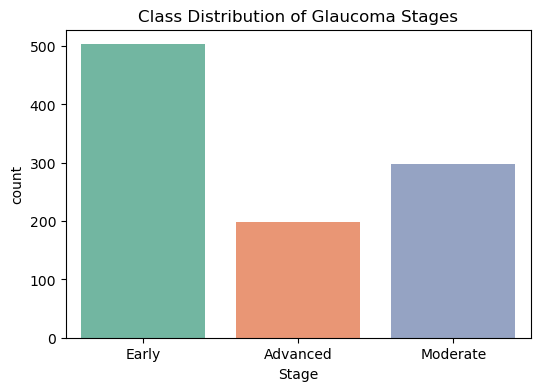

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Stage', palette='Set2')
plt.title('Class Distribution of Glaucoma Stages')
plt.show()

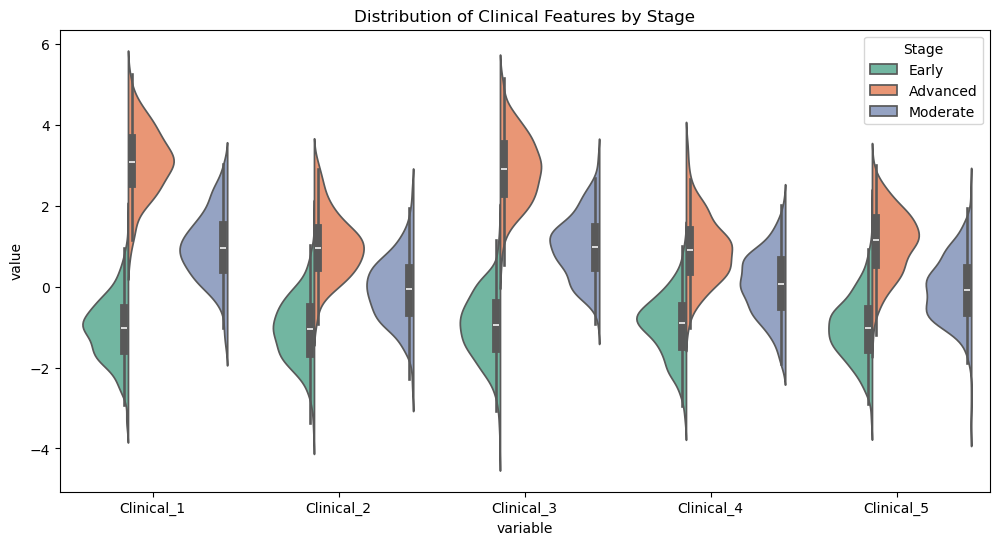

In [26]:
df_melted = df.melt(id_vars='Stage', value_vars=[f'Clinical_{i+1}' for i in range(5)])
plt.figure(figsize=(12, 6))
sns.violinplot(x='variable', y='value', hue='Stage', data=df_melted, split=True, palette='Set2')
plt.title('Distribution of Clinical Features by Stage')
plt.show()

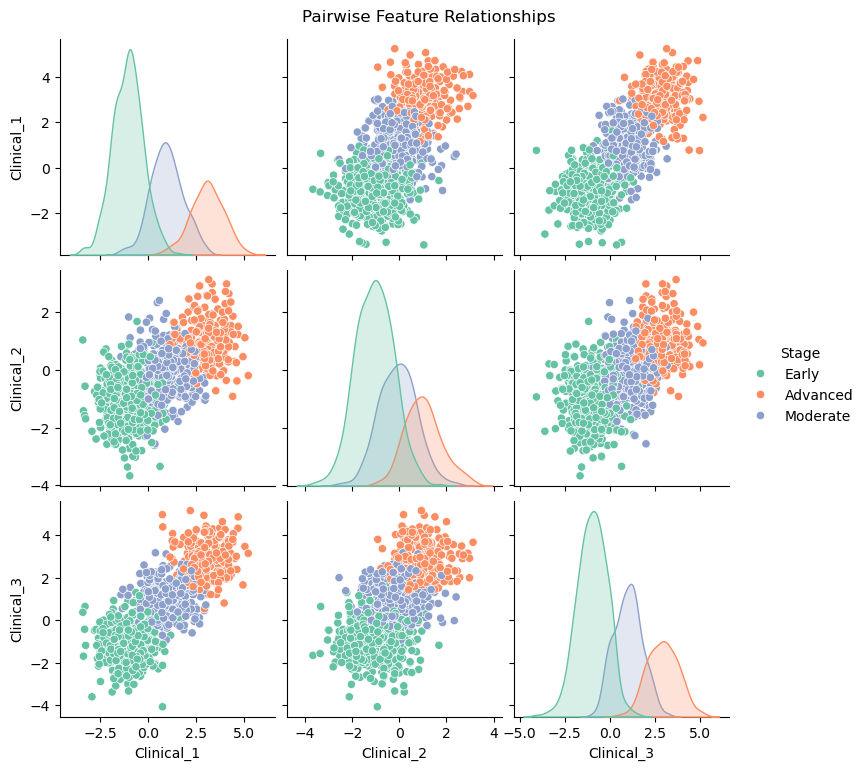

In [27]:
sns.pairplot(df, vars=[f'Clinical_{i+1}' for i in range(3)], hue='Stage', palette='Set2')
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show()

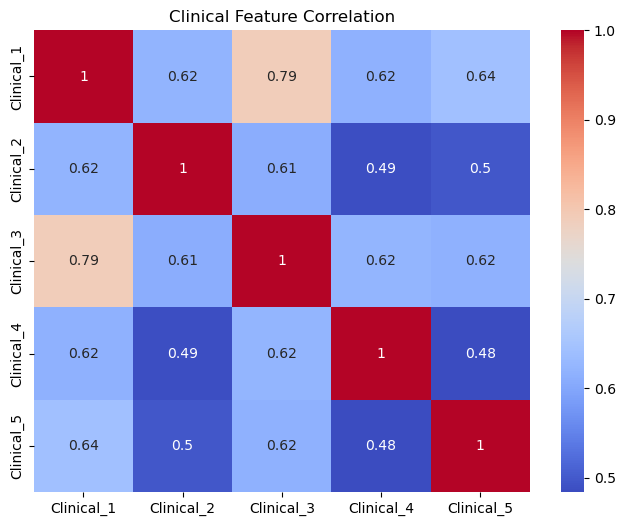

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[[f'Clinical_{i+1}' for i in range(5)]].corr(), annot=True, cmap='coolwarm')
plt.title("Clinical Feature Correlation")
plt.show()

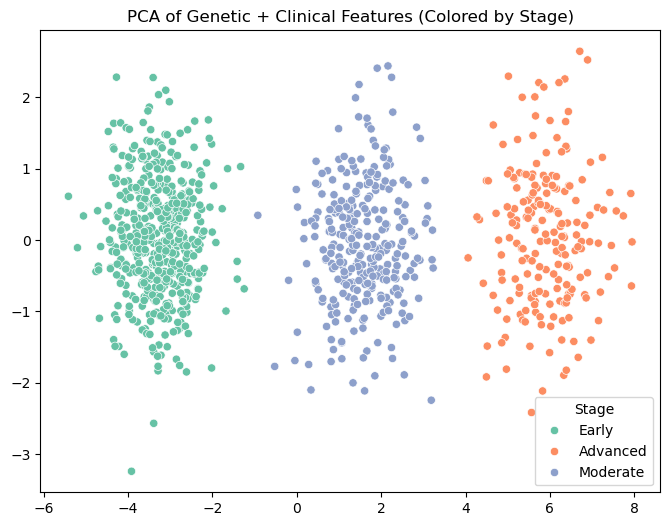

In [29]:
X_pca = PCA(2).fit_transform(df.iloc[:, :-1])
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Stage'], palette='Set2')
plt.title('PCA of Genetic + Clinical Features (Colored by Stage)')
plt.show()

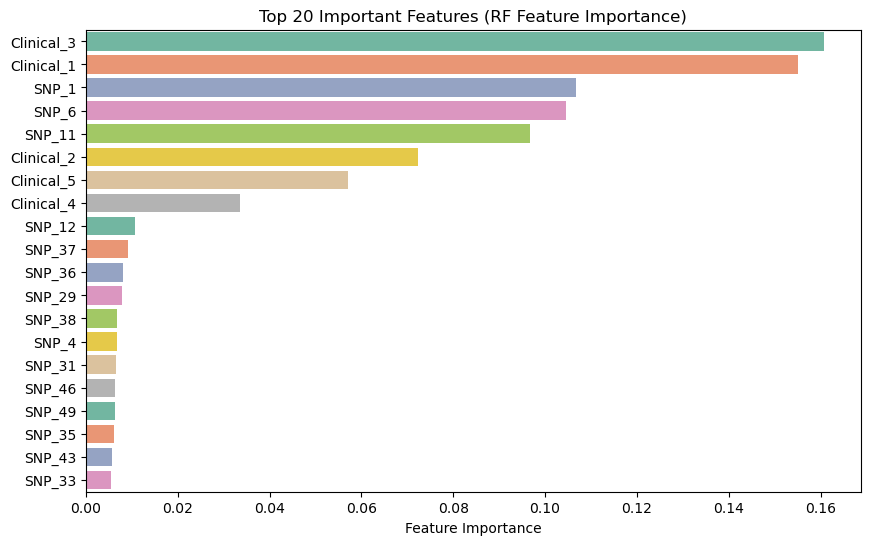

Top 10 key genetic markers: ['SNP_1', 'SNP_6', 'SNP_11', 'SNP_12', 'SNP_37', 'SNP_36', 'SNP_29', 'SNP_38', 'SNP_4', 'SNP_31']


In [30]:
X_full = df.iloc[:, :-1].values
y_full = LabelEncoder().fit_transform(df['Stage'])

rf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sel.fit(X_full, y_full)
importances = rf_sel.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [columns[i] for i in indices[:20]]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:20], y=[columns[i] for i in indices[:20]], palette='Set2')
plt.title('Top 20 Important Features (RF Feature Importance)')
plt.xlabel('Feature Importance')
plt.show()

print("Top 10 key genetic markers:", [f for f in top_features if "SNP" in f][:10])

In [31]:
X = df[top_features].values
y = LabelEncoder().fit_transform(df['Stage'])  
class_names = ['Early', 'Moderate', 'Advanced']

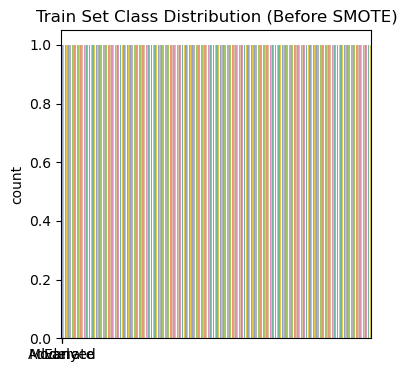

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
plt.figure(figsize=(4,4))
sns.countplot(y_train, palette='Set2')
plt.title('Train Set Class Distribution (Before SMOTE)')
plt.xticks(ticks=[0,1,2], labels=class_names)
plt.show()

Before SMOTE: Counter({1: 402, 2: 239, 0: 159})
After SMOTE: Counter({1: 402, 2: 402, 0: 402})


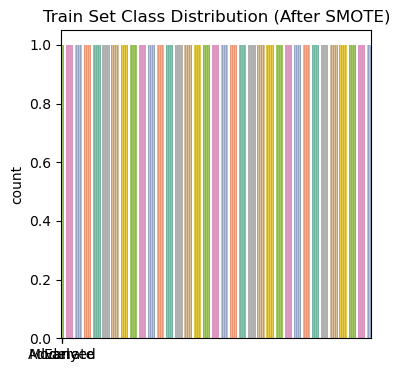

In [33]:
print("Before SMOTE:", Counter(y_train))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_res))
plt.figure(figsize=(4,4))
sns.countplot(y_res, palette='Set2')
plt.title('Train Set Class Distribution (After SMOTE)')
plt.xticks(ticks=[0,1,2], labels=class_names)
plt.show()

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 8, 16],
        'min_samples_split': [2, 5]
    },
    'DecisionTree': {
        'max_depth': [None, 6, 12],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

base_models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_results = {}
metrics_df = pd.DataFrame()

for name in ['RandomForest', 'DecisionTree', 'SVM']:
    print(f"\nTuning {name}...")
    grid = GridSearchCV(
        base_models[name], 
        param_grids[name], 
        scoring='f1_weighted', 
        cv=cv, 
        n_jobs=-1
    )
    grid.fit(X_res, y_res)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None
    acc_cv = cross_val_score(best_model, X_res, y_res, cv=cv, scoring='accuracy')
    f1_cv = cross_val_score(best_model, X_res, y_res, cv=cv, scoring='f1_weighted')
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    tuned_results[name] = {
        'best_params': grid.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'f1_cv': np.mean(f1_cv),
        'acc_cv': np.mean(acc_cv),
        'report': report,
        'cm': cm,
        'y_prob': y_prob,
        'model': best_model
    }
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted'),
        'CV Accuracy': np.mean(acc_cv),
        'CV F1': np.mean(f1_cv),
        'Best Params': grid.best_params_
    }])], ignore_index=True)
    print(f"{name} best params: {grid.best_params_}")
    print(classification_report(y_test, y_pred))
print("\nOptimized Model Performance Summary:")
print(metrics_df)


Tuning RandomForest...
RandomForest best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00        59

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Tuning DecisionTree...
DecisionTree best params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       1.00      1.00      1.00       101
           2       0.97      0.97      0.97        59

    accuracy                           0.98       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.98      0.98      0.98       200


Tuni

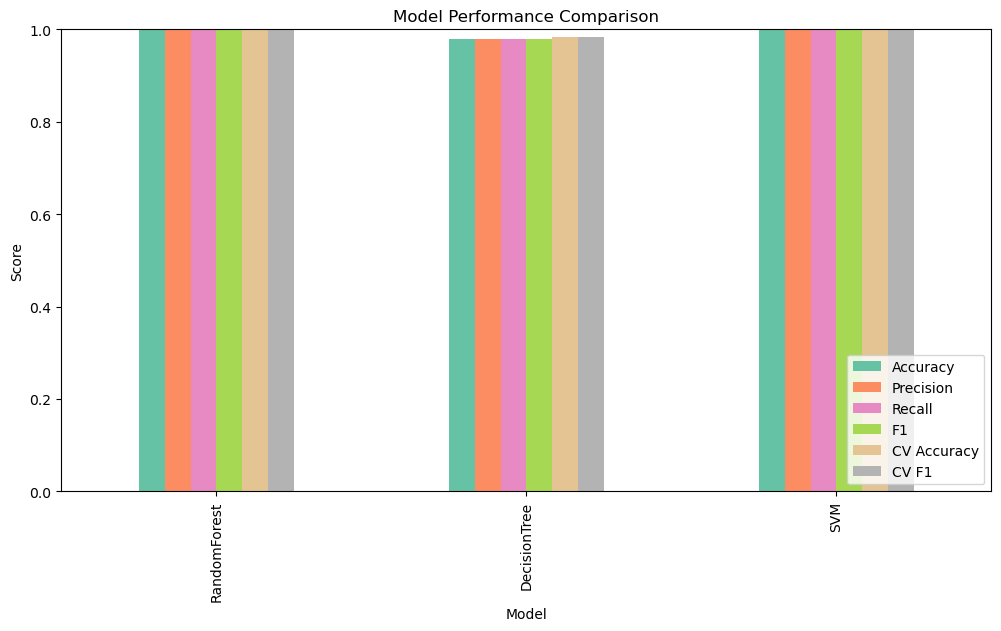

In [35]:
metrics_df = metrics_df.set_index('Model')
metrics_df[['Accuracy','Precision','Recall','F1','CV Accuracy','CV F1']].plot(kind='bar', figsize=(12,6), colormap='Set2')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


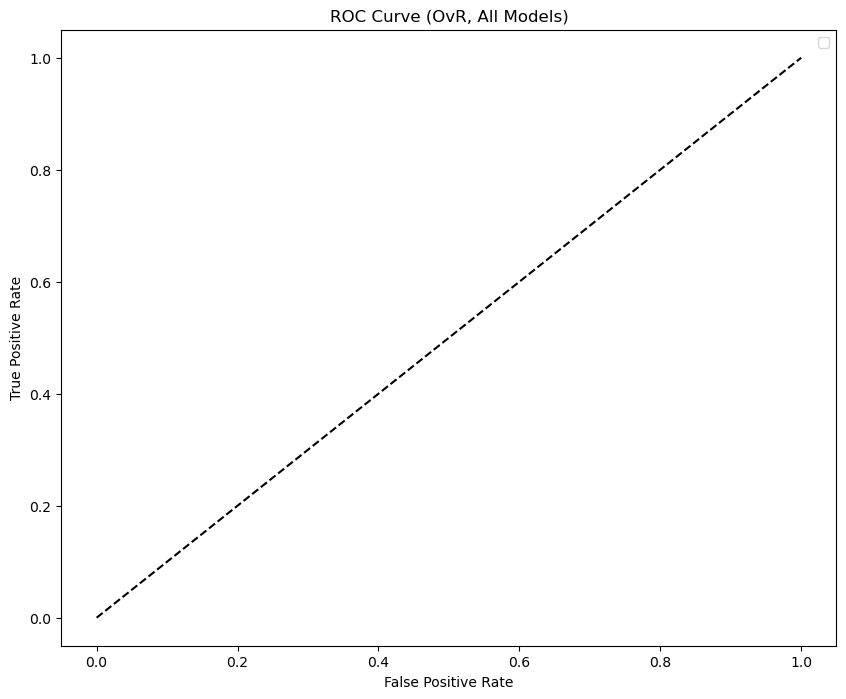

In [36]:
for name, res in results.items():
    plt.figure(figsize=(5,4))
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(f"\n{name} Classification Report")
    print(pd.DataFrame(res['report']).T)
    print("-"*40)
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0,1,2])
plt.figure(figsize=(10,8))
for name, res in results.items():
    if res['y_prob'] is not None:
        for i in range(3):  # for each class
            fpr, tpr, _ = roc_curve(y_test_bin[:,i], res['y_prob'][:,i])
            plt.plot(fpr, tpr, label=f"{name} - {class_names[i]}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (OvR, All Models)')
plt.legend()
plt.show()

In [37]:
explainer = shap.TreeExplainer(results['RandomForest']['model'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=top_features, plot_type="bar")
shap.summary_plot(shap_values, X_test, feature_names=top_features)

KeyError: 'RandomForest'

In [38]:
print("Model Comparison Table")
print(metrics_df)
print("\nBest model(s):")
accs = {k: v['accuracy'] for k, v in results.items()}
print(accs)
best_model_name = max(accs, key=accs.get)
print(f"\nBest performing model: {best_model_name}")

print("\nTop genetic markers potentially relevant for clinical progression:")
print([f for f in top_features if "SNP" in f][:10])

Model Comparison Table
              Accuracy  Precision  Recall    F1  CV Accuracy     CV F1  \
Model                                                                    
RandomForest      1.00       1.00    1.00  1.00     0.997510  0.997510   
DecisionTree      0.98       0.98    0.98  0.98     0.984246  0.984239   
SVM               1.00       1.00    1.00  1.00     0.997514  0.997514   

                                                    Best Params  
Model                                                            
RandomForest  {'max_depth': None, 'min_samples_split': 5, 'n...  
DecisionTree  {'criterion': 'entropy', 'max_depth': None, 'm...  
SVM            {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}  

Best model(s):
{}


ValueError: max() iterable argument is empty